# Ensemble Methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import (
    RandomForestRegressor,
    BaggingRegressor,
    RandomForestClassifier,
    AdaBoostRegressor,
    AdaBoostClassifier,
    GradientBoostingRegressor,
    VotingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Ensemble learning

Ensemble learning เป็นการใช้ algorithm หนึ่งหลาย ๆ ครั้ง เพื่อสร้าง algorithm ที่ดีขึ้น แบ่งได้เป็น 2 ประเภท ได้แก่
- <b>Parallel learner</b>: แต่ละ model ถูก trained ขนานกัน แล้วเอา prediction ที่ได้มารวมกัน เช่น random forest
- <b>Sequential learner</b>: แต่ละ model ถูก trained เป็นลำดับ เช่น boosted trees

<img src="../images/ensemble_learning.png" width="700" style="align: center"/><br />

## Bootstrap aggregation (bagging)

Bootstrap aggregation (bagging) เป็น parallel ensemble method วิธีหนึ่ง มีจุดประสงค์คือ <b>reduce variance</b> 

ในการทำ bagging เราจะไม่ใช้ทุก feature ใน model เดียว แต่สร้าง model หลายอัน แต่ละ model (เรียกว่า <b>weak learner</b>) จะสุ่มใช้ข้อมูลแค่บางส่วนและใช้แค่บาง feature (มีซ้ำกับ model อื่นบ้าง) และถูกเทรนพร้อมกัน (ขนานกัน) การสุ่มข้อมูลหรือ feature มาบางส่วนเพื่อเทรนแต่ละ model เรียกว่า <b>bootstrapping</b> ส่วนข้อมูลที่ไม่ได้ถูกใช้ (เรียกว่า <b>out-of-bag samples</b>) สามารถนำไปทำ pseudo test ได้

Prediction ที่ได้จากแต่ละ model จะต่างกันมาก
- สำหรับ regression task
    - เราจะเอา prediction จากทุก model มาเฉลี่ย
    - ใช้ `sklearn.ensemble.BaggingRegressor`
- สำหรับ classification task
    - สำหรับ classification task เราจะเลือก prediction ที่ซ้ำมากที่สุด (voting)
    - ใช้ `sklearn.ensemble.BaggingClassifier`
    
<img src="../images/bagging_prediction.png" width="500" /><br />

### Random forest

Random forest คือ bagging algorithm ที่มี decision tree เป็น weak learner (นั่นคือ random forest = bagged tree) สร้างได้โดยใช้ `sklearn.ensemble.RandomForestRegressor` หรือ `sklearn.ensemble.RandomForestClassifier`

<img src="../images/random_forest.png" width="800" /><br />

### Pros and cons of bagging

ข้อดีของ bagging เช่น
- ลด variance/overfitting
- ใช้ได้กับ model ทุกชนิด

ข้อเสียของ bagging เช่น
- มีโครงสร้างซับซ้อน
- ใช้เวลาเทรนนาน
- ไม่สนใจ performance ของแต่ละ weak learner

In [2]:
# Import data and drop duplicates
data = pd.read_csv('../data/greenhouse.csv').drop_duplicates()
data

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Average Temperature
0,0.98,514.5,294.0,110.25,7.0,0.0,18.440
4,0.90,563.5,318.5,122.50,7.0,0.0,24.560
5,0.90,563.5,318.5,122.50,7.0,0.0,23.420
6,0.90,563.5,318.5,122.50,7.0,0.0,22.935
7,0.90,563.5,318.5,122.50,7.0,0.0,24.640
...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,0.4,19.640
764,0.62,808.5,367.5,220.50,3.5,0.4,16.710
765,0.62,808.5,367.5,220.50,3.5,0.4,16.775
766,0.62,808.5,367.5,220.50,3.5,0.4,16.545


In [3]:
# Features (X) and target (y)
X = data[['Overall Height', 'Glazing Area']]
y = data['Average Temperature']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=5)

In [4]:
# Initialise a random forest regressor with 100 trees 
forest_regressor = RandomForestRegressor(n_estimators=100)

In [5]:
# 10-fold cross validation
cv_scores = -1*cross_val_score(forest_regressor, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
cv_scores.mean()

12.834057466644879

In [6]:
# Initialise a random forest regressor with 100 trees 
forest_regressor = RandomForestRegressor(
    n_estimators=100,
    oob_score=True  # Use out-of-bag samples to evaluate model performance
).fit(X_train, y_train)
# Out-of-bag score and error
oob_score = forest_regressor.oob_score_
oob_error = 1 - oob_score
print(f"OOB score = {oob_score}\nOOB error = {oob_error}")

OOB score = 0.8640329076504297
OOB error = 0.13596709234957027


In [7]:
# Initialise a bagged linear regressors
bagged_linear_model = BaggingRegressor(LinearRegression(), n_estimators=50)
# 10-fold cross validation
cv_scores = -1*cross_val_score(bagged_linear_model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
cv_scores.mean()

13.297723651671873

In [8]:
# Import data and drop duplicates
data2 = pd.read_csv('../data/geochem.csv').drop_duplicates()
data2

,Ca_ICP_PCT,K_ICP_PCT,pH
0,2.72,0.03,2
1,0.35,0.08,0
2,0.40,0.08,0
3,0.59,0.04,0
4,2.39,0.03,2
...,...,...,...
834,0.50,0.17,0
835,0.63,0.23,1
836,0.55,0.20,0
837,0.31,0.03,0


In [9]:
# Features (X) and target (y)
X2, y2 = data2.drop(columns='pH'), data2['pH']
# Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.8, random_state=3)

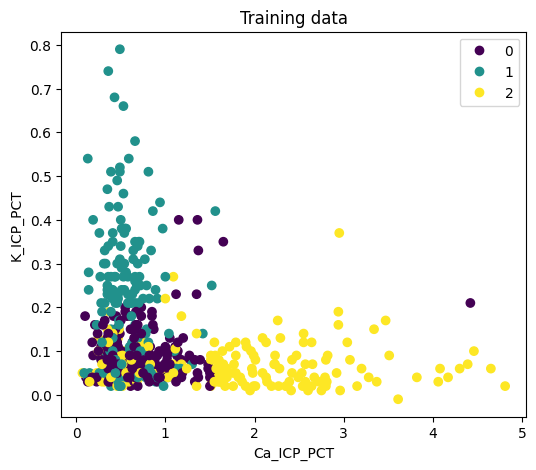

In [10]:
# Plot training data
fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(X2_train['Ca_ICP_PCT'], X2_train['K_ICP_PCT'], c=y2_train)
ax.set(xlabel='Ca_ICP_PCT', ylabel='K_ICP_PCT', title='Training data')
ax.legend(*scatter.legend_elements());

In [11]:
# Initialise and fit a random forest classifier with a max depth of 5
forest_classifier = RandomForestClassifier(max_depth=5).fit(X2_train, y2_train)

In [12]:
# Compute accuracy score
forest_classifier.score(X2_test, y2_test)

0.7682119205298014

C:\Users\Khuna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


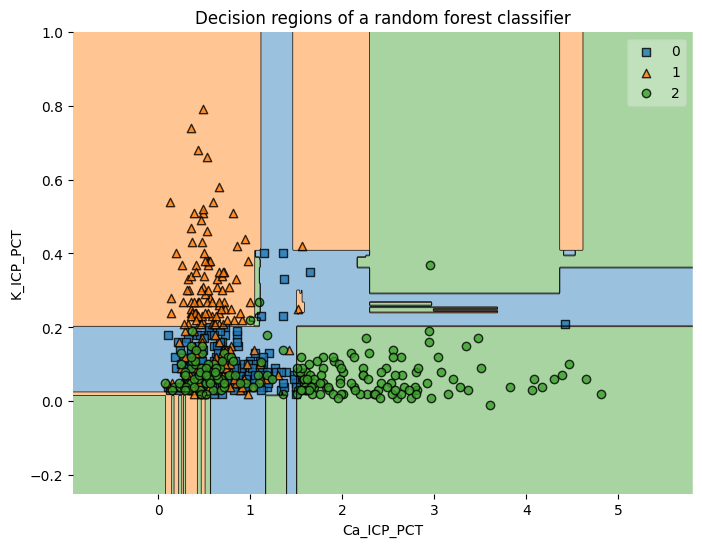

In [13]:
# Plot decision regions
fig, ax = plt.subplots(figsize=(8, 6))
fig = plot_decision_regions(X2_train.values, y2_train.values, clf=forest_classifier)
ax.set(
    xlabel='Ca_ICP_PCT',
    ylabel='K_ICP_PCT',
    title='Decision regions of a random forest classifier',
    ylim=(-0.25, 1)
);

## Boosting

Boosting เป็น sequential ensemble method วิธีหนึ่ง มีจุดประสงค์คือ <b>reduce bias</b>

ในการทำ boosting เราจะสร้าง weak learner ขึ้นมาเป็นลำดับ โดยเอา prediction ที่ได้จาก weak learner ก่อนหน้ามาเป็น input ของ weak learner ถัดไป โดยแต่ละ weak learner ถ่วงน้ำหนักไว้ต่างกัน (weak learner ที่ดีกว่าจะมีน้ำหนักมากกว่า)

### Adaptive boosting (AdaBoost) 

กำหนดน้ำหนักเริ่มต้นให้ข้อมูล $x_i$ คือ $w_i=\frac{1}{n}$ ($n$ คือจำนวนข้อมูลทั้งหมด) นำข้อมูลทั้งหมดไปเทรน weak learner ถ้าใช้ข้อมูล $x_i$ แล้วทำนายผิด จะเพิ่ม $w_i$ แต่ถ้าทำนายถูก จะลด $w_i$ เมื่อเริ่มเทรน weak learner อันต่อไป ให้ใช้ข้อมูลที่มีน้ำหนักมากกว่าก่อน ทำไปเรื่อย ๆ จนกว่าจะได้ model ที่ดีพอหรือมีจำนวน weak learner ครบตามที่ต้องการ

<img src="../images/adaboost.png" width="500" /><br />

เราสามารถทำ adaptive boosting ได้โดยใช้ `sklearn.ensemble.AdaBoostRegressor` หรือ `sklearn.ensemble.AdaBoostClassifier`

In [14]:
# Initialise an adaptively boosted tree regressor with a max depth of 3
adaboost_regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3))
# 10-fold cross validation
cv_scores = -1*cross_val_score(adaboost_regressor, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
cv_scores.mean()

13.148587086644493

In [15]:
# Initialise and fit an adaptively boosted tree classifier
# with a max depth of 5 and the number of trees of 50
adaboost_classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=10
).fit(X2_train, y2_train)

In [16]:
# Compute accuracy score
adaboost_classifier.score(X2_test, y2_test)

0.6423841059602649

C:\Users\Khuna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


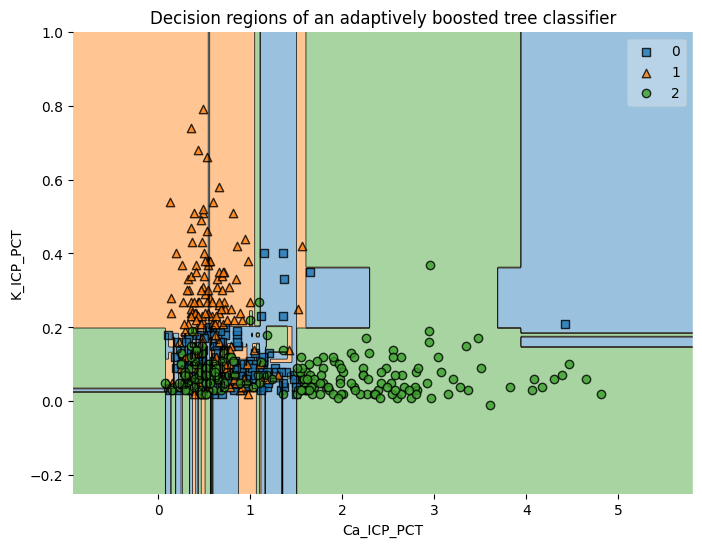

In [17]:
# Plot decision regions
fig, ax = plt.subplots(figsize=(8, 6))
fig = plot_decision_regions(X2_train.values, y2_train.values, clf=adaboost_classifier)
ax.set(
    xlabel='Ca_ICP_PCT',
    ylabel='K_ICP_PCT',
    title='Decision regions of an adaptively boosted tree classifier',
    ylim=(-0.25, 1)
);

### Gradient boosting

Gradient boosting มี performance ดีกว่า adaptive boosting แต่ใช้ได้กับ tree เท่านั้น ในขณะที่ adaptive boosting สามารถใช้ได้กับ weak learner ทุกชนิด

เริ่มจากเทรน tree แรกสุด หา residual (สำหรับ regression) หรือ log loss (สำหรับ classification) ของมัน จากนั้นเทรน tree ถัดไปให้ทำนาย residual/log loss ของ tree ก่อนหน้า ไปเรื่อย ๆ (residual/log loss จะลดลงเรื่อย ๆ)

<img src="../images/gradient_boosting.png" width="600" /><br />

เราสามารถทำ gradient boosting ได้โดยใช้ sklearn.ensemble.GradientBoostingRegressor (สำหรับ regression task) หรือ sklearn.ensemble.GradientBoostingClassifier (สำหรับ classification task)

In [18]:
# Initialise and fit a gradient-boosted regressor
gb_regressor = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1
).fit(X_train, y_train)
# Compute r2 score
gb_regressor.score(X_test, y_test)

0.8823976698022429

### Extreme gradient boosting

Extreme gradient boosting เร็วกว่า gradient boosting แต่ต้องใช้ `xgboost` module

### Pros and cons of boosting

ข้อดีของ boosting เช่น
- ลด bias
- model ที่มีน้ำหนักกว่าจะมีอิทธิพลต่อ final decision มากกว่า

ข้อเสียของ boosting เช่น
- computationally expensive
- ช้ากว่า bagging เพราะต้องเทรนทีละ tree ไม่สามารถเทรนพร้อมกันทุก tree ได้
- overfit ได้ง่าย
- อ่อนไหวต่อ outlier

## Model stacking

Stacking เป็นการใช้ algorithm ที่ต่างกัน แล้วเอา prediction ที่ได้มารวมกัน โดยเอามาเฉลี่ย (สำหรับ regression) หรือทำ voting (สำหรับ classification)

เมื่อเอา algorithm ที่ต่างกันมารวมกันจะทำให้ decision boundary ไม่ตั้งฉากกันแล้ว

### Simple aggregation

ใช้ `sklearn.ensemble.VotingRegressor` หรือ `sklearn.ensemble.VotingClassifier`

In [19]:
# Initialise and fit a voting classifier
ensemble = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(max_depth=2)),
        ("lr", LogisticRegression())
    ],
    # voting='hard' เลือก prediction ที่ซ้ำมากที่สุด
    # voting='soft' เลือก prediction ที่มี probability (predict_proba) เฉลี่ยมากที่สุด
    voting='soft',
    # กำหนดให้ random forest classifier กับ logistic regressor มีน้ำหนักเท่ากัน
    weights=[1, 1]
).fit(X2_train, y2_train)

In [20]:
# Compute accuracy score
ensemble.score(X2_test, y2_test)

0.7549668874172185

C:\Users\Khuna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


C:\Users\Khuna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


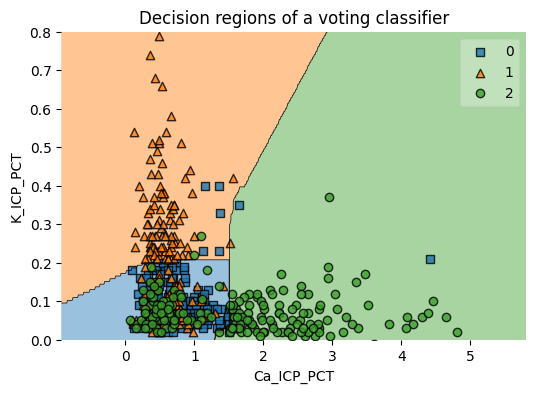

In [21]:
# Plot decision regions
fig, ax = plt.subplots(figsize=(6, 4))
fig = plot_decision_regions(X2_train.values, y2_train.values, clf=ensemble)
ax.set(
    xlabel='Ca_ICP_PCT',
    ylabel='K_ICP_PCT',
    title='Decision regions of a voting classifier',
    ylim=(0, 0.8)
);

### Multi-layer stacking

แทนที่จะเอา prediction มาเฉลี่ยหรือทำ voting เราจะเอา prediction เหล่านั้นมาตัดสินโดยใช้ final estimator

ทำได้โดยใช้ `sklearn.ensemble.StackingRegressor` หรือ `sklearn.ensemble.StackingClassifier`

In [22]:
# Initialise and fit a multi-layer stacking classifier
ensemble = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(max_depth=2)),
        ("knn", KNeighborsClassifier(n_neighbors=10))
    ],
    final_estimator=LogisticRegression()
).fit(X2_train, y2_train)

In [23]:
# Compute accuracy score
ensemble.score(X2_test, y2_test)

0.7615894039735099

C:\Users\Khuna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


C:\Users\Khuna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


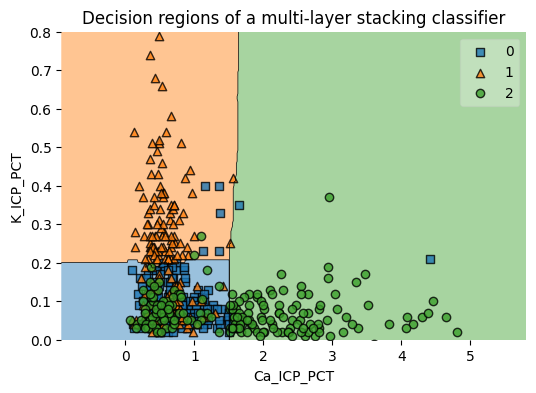

In [24]:
# Plot decision regions
fig, ax = plt.subplots(figsize=(6, 4))
fig = plot_decision_regions(X2_train.values, y2_train.values, clf=ensemble)
ax.set(
    xlabel='Ca_ICP_PCT',
    ylabel='K_ICP_PCT',
    title='Decision regions of a multi-layer stacking classifier',
    ylim=(0, 0.8)
);